In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import joblib
from sklearn.decomposition import PCA

In [2]:
%matplotlib inline
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
from scripts.data_utils.plots import scatter, visualize_scatter_with_images,plot_similar_image,  plot_random_directions, plot_subset_of_directions 
from scripts.data_utils.generators import SimilarityImageGenerator, generate_directional_dataset, flatten_directional_data
from scripts.data_utils.grid_utils import pad_data_to_fit_patch,blockshaped, unblockshaped, plot_embeddings, plot_patched_directions, create_patched_data


#load  seimsic data
chapterName = "variational_autoencoder-svh"
output_folder = "/home/andykamp/master/quantify_seismic_similarity/notebooks/" + chapterName

#load  seimsic data
data_cube = np.load("/home/andykamp/master/quantify_seismic_similarity/data/processed/f3_entire_int8.npy")


print("img shape", data_cube.shape)

directions, inline_samples, xline_samples, tline_samples,data, labels, num_samples, shape = generate_directional_dataset(data_cube)
#print("labels", labels["inline"], labels["xline"], labels["tline"])

/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/pyth

img shape (651, 951, 462)
651 951 462


padding_needed {'inline': 53, 'xline': 9, 'tline': 50}
Found inline
Found xline
Found tline
padded_data (704, 960, 512)
padded_data (960, 704, 512)
padded_data (512, 960, 704)


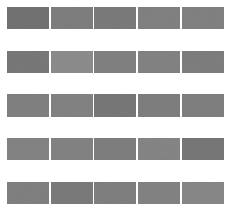

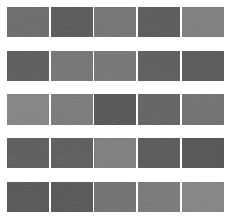

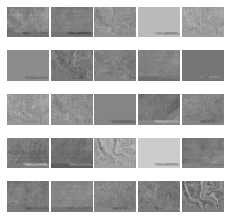

In [3]:
## We then pad each direction to be able to grid it to a 16, 32, 64 ++ grid. 
# The reason we choose such numbers are gupu optimilization (LINK)

# but beforre we can do this we need to pad the images to go up in the wanted patch size
patch_size = 64

padded_data = pad_data_to_fit_patch(data, patch_size, directions, num_samples, output_folder)
for dir in directions:
    print("padded_data", padded_data[dir].shape)
    
# plot supsets of each direction to visualize patterns in each direction
plot_subset_of_directions(padded_data, directions, 100)


In [4]:
# we have now padded all directions and can extract patched of patch_size 

patched_data, patched_labels, patched_labels_per_image, patched_labels_per_grid_cell, patched_labels_per_grid_cell, patched_grid_sizes, patched_num_smaples =  create_patched_data(padded_data, patch_size, directions)



dir shape (704, 960, 512)
nm 15 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [703. 703. 703. 703. 703. 703. 703. 703. 703. 703.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [110. 111. 112. 113. 114. 115. 116. 117. 118. 119.]
dir shape (960, 704, 512)
nm 11 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [959. 959. 959. 959. 959. 959. 959. 959. 959. 959.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [78. 79. 80. 81. 82. 83. 84. 85. 86. 87.]
dir shape (512, 960, 704)
nm 15 11 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84

In [5]:
from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

import numpy as np
import pandas as pd
K.clear_session()
np.random.seed(237)

direction = "inline"
print(patched_data[direction].shape)
data = np.expand_dims(patched_data[direction],axis=-1)
print(data.shape)
length = data.shape[0]//10
val_split = 0.1

# flatten data from (-1, patch_size, patch_size) to  (-1, 4064) 
data = data.reshape(patched_grid_sizes[direction][0], -1)
# find max abs value in data 
max_val = max(abs(np.min(data)),abs(np.max(data))) *0.7 # make sure to clipp sides 
print("abs max ",max_val) # --> outputs 127
# normalize between -1 and 1 
data = data/max_val 
# push first to get values between [0,2] and then devide by 2 to get values between [0,1)]
data = (data + 1) /2
data = np.clip(data, 0, 1)
print("MIN_MAX", np.min(data), np.max(data)) #--> outputs 0 and one 


# reshape to (-1, 64, 64)
data = data.reshape(-1, patch_size, patch_size,1)

Using TensorFlow backend.





(84480, 64, 64)
(84480, 64, 64, 1)
abs max  88.89999999999999


KeyboardInterrupt: 

In [9]:
# convert the greyscale to rgb by repeating the greyscal 3 times 
data = np.repeat(data[..., np.newaxis], 3, -1)

In [6]:
print(data.shape)
filename = output_folder + "/grey_data_inline.npy"
if not os.path.exists(filename):
    print("saving rgba data")
    np.save(filename,data)

else: 
    print("Found rgba data")
    data = np.load(filename)

(84480, 4096)
Found rgba data


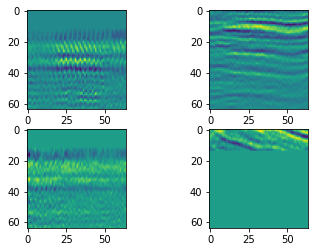

In [7]:
plt.figure(1)
plt.subplot(221)
plt.imshow(data[131][:,:,0])

plt.subplot(222)
plt.imshow(data[160][:,:,0])

plt.subplot(223)
plt.imshow(data[370][:,:,0])

plt.subplot(224)
plt.imshow(data[110][:,:,0])
plt.show()

# Train PCA

Fit a PCA model on a random sample of 100k (should capture the distribution of the variation pretty well)

#### Notes:

* Scale pixel to [0,1] (not strictly necessary)
* Don't use PCA whitening
* Use 1000 components

In [8]:
def train_pca(n_components, N=80000):
    X_dataset, y_dataset = data[:N], patched_labels_per_image[direction][:N]#np.moveaxis(X_dataset[1][:N], 1, 3), y_dataset[1][:N]

    #X_dataset, y_dataset = np.moveaxis(X_dataset[1][:], 1, 3), y_dataset[1][:]
    
    np.random.seed(0)
    index = np.random.choice(len(X_dataset), N, replace=False)
    X_dataset, y_dataset = X_dataset[index], y_dataset[index]
    
    print('Sample Size: %d' % N)
    print('Data Types X=%s, y=%s' % (X_dataset.dtype, y_dataset.dtype))
    print('Shape X=%s, y=%s' % (X_dataset.shape, y_dataset.shape))
    
    pca = PCA(n_components=n_components, whiten=False)
    
    start = time.time()
   
    # Reshape to 1-D array
    shape = X_dataset.shape
    X_reshape = X_dataset.reshape((shape[0], -1))
    X_reshape.shape
    print("Done reshaping,", X_reshape.shape)
    pca.fit(X_reshape)
    X_pca = pca.transform(X_reshape)
    
    end = time.time()
    elapsed = end - start
    print('Fit time elapsed: {}'.format(elapsed))
    
    return pca
   
n_components = 2000
pca = train_pca(n_components=n_components)



Sample Size: 80000
Data Types X=float64, y=float64
Shape X=(80000, 64, 64, 1), y=(80000,)
Done reshaping, (80000, 4096)
Fit time elapsed: 173.59279084205627


In [17]:
model_path = output_folder+ '/pca_%d.pkl' % n_components
print('Dumping pca (%d) model to: %s' % (n_components, model_path)) 
joblib.dump(pca, model_path)

Dumping pca (1000) model to: /home/andykamp/master/quantify_seismic_similarity/notebooks/variational_autoencoder-svh/pca_1000_rgb.pkl


['/home/andykamp/master/quantify_seismic_similarity/notebooks/variational_autoencoder-svh/pca_1000_rgb.pkl']

# Test PCA

Display original and reconstructed images to ensure that PCA worked correctly.

In [18]:
# Test PCA model
pca = joblib.load(model_path)
pca

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [21]:
def display_grid(dataset, digit_size=64, grid_size=5, seed=None):
    # Display some digits to figure out what's going on
    figure = np.zeros((digit_size * grid_size, digit_size * grid_size))#,3))
    if seed is not None:
        np.random.seed(seed)
    for i in range(grid_size):
        for j in range(grid_size):
            digit = np.squeeze(dataset[np.random.randint(len(dataset))])
            #plt.imshow(digit)
            #plt.show()
            d_x, d_y = i * digit_size, j * digit_size
            figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit #,:] = digit
            
    plt.figure(figsize=(5, 5))
    plt.imshow(figure)
    plt.show()

(84480, 64, 64, 3) (84480,)


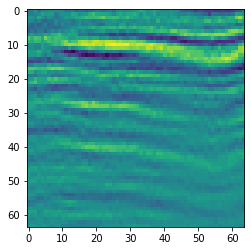

Originals
(1000, 64, 64, 3) (1000,)


ValueError: could not broadcast input array from shape (64,64,3) into shape (64,64)

In [22]:
# convert the greyscale to rgb by repeating the greyscal 3 times 
#data = np.repeat(data[..., np.newaxis], 3, -1)
X_dataset, y_dataset = data, patched_labels_per_image[direction]#np.moveaxis(X_dataset[1][:N], 1, 3), y_dataset[1][:N]
print(X_dataset.shape, y_dataset.shape)
sample_size = 1000
plt.imshow(X_dataset[1000][:,:,0])
plt.show()
print("Originals")
index = np.random.choice(len(X_dataset), sample_size, replace=False)
X_dataset, y_dataset = X_dataset[index], y_dataset[index]
print(X_dataset.shape, y_dataset.shape)
display_grid(X_dataset, seed=0)

print("Reconstructed PCA")
X_reshape = X_dataset.reshape((X_dataset.shape[0], -1)) 
X_pca = pca.transform(X_reshape)
X_recon = np.clip(pca.inverse_transform(X_pca), 0.0, 0.999)
X_recon_reshape = X_recon.reshape(X_dataset.shape) 
display_grid(X_recon_reshape, seed=0)

Reconstructed PCA images looks pretty similar.